The following codes are originally from [here](https://bipinkrishnan.github.io/ml-recipe-book/image_captioning.html), and slightly modified

# 0. Dataset

We will be using the flickr8k image captioning dataset which contain images as well as 5 captions corresponding to a single image. The raw dataset has an images folder which contain all the images and a captions.txt file which has the captions corresponding to each image in the images folder. we will use the captions with ‘caption_number’ equal to 1.

# 1. Preparing the data

In [1]:
from pathlib import Path

import pandas as pd

In [2]:
# create an empty dataframe with 'imgs' column
df = pd.DataFrame(columns=["imgs"])
# we will store the image files and captions here before putting it into dataframe
imgs, captions = [], []
# directory where the dataset is present
root_dir = Path("../data/flickr8k")

In [3]:
# get the contents of 'captions.txt' file
with open(root_dir / "captions.txt", "r") as f:
    content = f.readlines()

In [4]:
content[:5]  # Just to show 5 samples

['image_name|caption_number|caption_text\n',
 '1000268201_693b08cb0e.jpg|0|A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg|1|A girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg|2|A little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg|3|A little girl climbing the stairs to her playhouse .\n']

In [5]:
for line in content:
    line = line.strip().split("|")

    # extract the required informations
    img_path = line[0]
    caption_number = line[1]
    caption = line[-1]

    # check if the caption_number is equal to 1
    if caption_number == "1":
        # store the image path
        imgs.append(root_dir / "images" / img_path)
        # store the caption
        captions.append(caption)

In [6]:
df.loc[:, "imgs"] = imgs
df.loc[:, "captions"] = captions

In [7]:
df

,imgs,captions
0,..\data\flickr8k\images\1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1,..\data\flickr8k\images\1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
2,..\data\flickr8k\images\1002674143_1b742ab4b8.jpg,A little girl is sitting in front of a large p...
3,..\data\flickr8k\images\1003163366_44323f5815.jpg,A man lays on the bench to which a white dog i...
4,..\data\flickr8k\images\1007129816_e794419615.jpg,A man wears an orange hat and glasses .
...,...,...
8086,..\data\flickr8k\images\990890291_afc72be141.jpg,A man is doing a wheelie on a mountain bike .
8087,..\data\flickr8k\images\99171998_7cc800ceef.jpg,A group of people sit atop a snowy mountain .
8088,..\data\flickr8k\images\99679241_adc853a5c0.jpg,A large bird stands in the water on the beach .
8089,..\data\flickr8k\images\997338199_7343367d7f.jpg,a woman behind a scrolled wall is writing


Here we will use encoder-decoder type model, but the problem is that the input is an image and output is text. As we had `AutoTokenizer` to deal the text data, the transformers library also has something called `AutoFeatureExtractor` to deal with image data.

The tokenizer we load using `AutoTokenizer` will process the text and prepare it in a format which can be directly fed to the model. Similarly, the feature extractor loaded using `AutoFeatureExtractor` will process the image and prepare it in a format which can be directly fed into the vision model.

We will load the feature extractor from [vision transformer checkpoint](https://huggingface.co/google/vit-base-patch16-224-in21k) and tokenizer from [gpt2 checkpoint](https://huggingface.co/gpt2):

In [8]:
from transformers import AutoFeatureExtractor, AutoTokenizer

In [9]:
encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"

In [10]:
feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)

For the tokenizer, we will set the maximum length to 128, which means, the tokenizer will truncate captions longer than 128 and add padding to captions shorter than 128. So we need to set a token id for padding, otherwise we will get an error:

In [11]:
tokenizer

PreTrainedTokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=True, padding_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'})

In [12]:
tokenizer.pad_token

Using pad_token, but it is not set yet.


In [13]:
tokenizer.pad_token = tokenizer.eos_token

In [14]:
tokenizer.pad_token

'<|endoftext|>'

Let’s take an example image and a caption to see the outputs after applying feature_extractor and tokenizer respectively:

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [16]:
# maximum length for the captions
max_length = 128
sample = df.iloc[0]

# sample image
image = Image.open(sample["imgs"]).convert("RGB")
# sample caption
caption = sample["captions"]

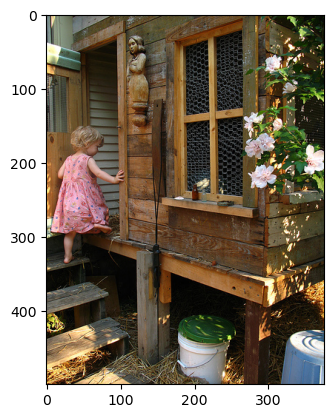

In [17]:
plt.imshow(image)

In [18]:
np.array(image).shape

(500, 375, 3)

In [19]:
caption

'A girl going into a wooden building .'

In [20]:
# apply feature extractor on the sample image
inputs = feature_extractor(images=image, return_tensors="pt")  # 'pt' = pytorch tensor

In [21]:
inputs

{'pixel_values': tensor([[[[-0.3569, -0.1294, -0.0902,  ..., -0.9686, -0.9529, -0.9529],
          [-0.3804, -0.1137, -0.0667,  ..., -0.9373, -0.9451, -0.9059],
          [-0.3961, -0.0824, -0.0510,  ..., -0.9373, -0.9451, -0.9216],
          ...,
          [ 0.4588,  0.1765,  0.3412,  ...,  0.6627,  0.2941,  0.2941],
          [ 0.3804,  0.3882,  0.7255,  ...,  0.6471,  0.3176,  0.3176],
          [ 0.6235,  0.6392,  0.4667,  ...,  0.6078,  0.3098,  0.3255]],

         [[-0.3176,  0.0039,  0.0510,  ..., -0.9765, -0.9529, -0.9373],
          [-0.3412,  0.0118,  0.0824,  ..., -0.9294, -0.9216, -0.8353],
          [-0.3804,  0.0353,  0.1059,  ..., -0.9294, -0.8980, -0.8275],
          ...,
          [-0.1529, -0.3725, -0.0431,  ...,  0.7333,  0.4510,  0.4431],
          [-0.2471,  0.0118,  0.3255,  ...,  0.7098,  0.4431,  0.4431],
          [-0.0118,  0.1608, -0.0431,  ...,  0.6784,  0.4431,  0.4431]],

         [[-0.2392, -0.0196, -0.0039,  ..., -0.9765, -0.9686, -0.9608],
          [-0

In [22]:
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


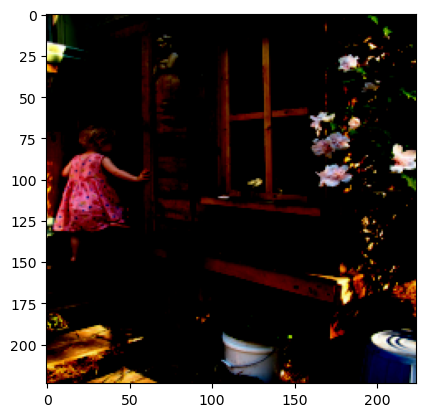

In [23]:
# image after feature extractor

plt.imshow(inputs["pixel_values"].permute(0, 2, 3, 1).numpy()[0])

In [24]:
# apply tokenizer
outputs = tokenizer(
    caption,
    max_length=max_length,
    truncation=True,
    padding="max_length",
    return_tensors="pt",
)

In [25]:
outputs

{'input_ids': tensor([[   32,  2576,  1016,   656,   257, 13510,  2615,   764, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [26]:
outputs["input_ids"].shape

torch.Size([1, 128])

As you can see, for the ‘Outputs’, since the caption is smaller than 128, padding token id(50256) is added to make the length equal to 128.

Now, let’s write a normal dataset loading class as we usually do in pytorch. We will pass the dataframe we just created and extract the images and captions. Then for each each image and caption we apply the `feature_extractor` and `tokenizer`. Finally, we return the processed inputs and outputs.

In [27]:
from torch.utils.data import Dataset

In [28]:
class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = df["imgs"].values
        self.captions = df["captions"].values

    def __getitem__(self, idx):
        # everything to return is stored inside this dict
        inputs = dict()

        # load the image and apply feature_extractor
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors="pt")

        # load the caption and apply tokenizer
        caption = self.captions[idx]
        labels = tokenizer(
            caption,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )["input_ids"][0]

        # store the inputs(pixel_values) and labels(input_ids) in the dict we created
        inputs["pixel_values"] = image["pixel_values"].squeeze()
        inputs["labels"] = labels
        return inputs

    def __len__(self):
        return len(self.images)

Let’s split our dataframe into training and testing set:

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

Now we will load each image and caption of our dataset using the LoadDataset class we just created:

In [31]:
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)

# 2. Training the model

For this task, we have a special class called `VisionEncoderDecoderModel`(you can read more about it [here](https://huggingface.co/docs/transformers/main/en/model_doc/vision-encoder-decoder#transformers.VisionEncoderDecoderModel)) where we can pass the name of the vision model and the language model we need for the encoder and the decoder respectively.

Loading our encoder-decoder model for this task is simple as this:

In [32]:
from transformers import VisionEncoderDecoderModel

In [33]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint, decoder_checkpoint
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.9.crossattention.c_proj.weight', 'h.9.crossattention.q_attn.weight', 'h.5.crossattention.bias', 'h.3.crossattention.bias', 'h.5.crossattention.c_proj.weight', 'h.9.crossattention.bias', 'h.8.crossattention.bias', 'h.5.ln_cross_attn.weight', 'h.3.crossattention.c_proj.bias', 'h.8.crossattention.c_attn.weight', 'h.5.crossattention.c_attn.weight', 'h.4.crossattention.q_attn.weight', 'h.6.crossattention.masked_bias', 'h.3.crossattention.c_proj.weight', 'h.10.crossattention.c_proj.weight', 'h.5.crossattention.q_attn.weight', 'h.11.crossattention.bias', 'h.2.crossattention.c_attn.weight', 'h.7.crossattention.q_attn.weight', 'h.0.crossattention.masked_bias', 'h.3.crossattention.c_attn.weight', 'h.2.crossattention.c_proj.weight', 'h.4.crossattention.c_proj.bias', 'h.11.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.4.crossattention.masked_bias', 'h.2.crossa

If you don’t set a value for `decoder_start_token_id` and `pad_token_id` in the model config, you will get an error:

So, before proceeding any further, let’s set those values:

In [34]:
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In order to get good and meaningful captions from the model, we should use beam search instead of greedy search while generating the caption. For that, we just have to set a value greater than 1 for `num_beams` in model config:

In [35]:
# set number of beams for beam search to 4
num_beams = 4
model.config.num_beams = num_beams

And, now it’s time to train the model. We will use the `Seq2SeqTrainer` from transformers library for this. Before that we need to pass some arguments to control the training of our model, we will do that first:

In [36]:
from transformers import Seq2SeqTrainingArguments

In [37]:
# batch size
bs = 8

training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator",  # name of the directory to store training outputs
    evaluation_strategy="epoch",  # evaluate after each epoch
    per_device_train_batch_size=bs,  # batch size during training
    per_device_eval_batch_size=bs,  # batch size during evaluation
    learning_rate=5e-5,
    weight_decay=0.01,  # weight decay parameter for Adam optimizer
    num_train_epochs=5,  # number of epochs to train
    save_strategy="epoch",  # save checkpoints after each epoch
    report_to="none",  # prevent reporting to wandb, mlflow...
)

Now let’s create the trainer and start the training:

In [38]:
from transformers import Seq2SeqTrainer, default_data_collator

In [39]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,  # it was originally feature_extractor 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

In [40]:
trainer.train()

***** Running training *****
  Num examples = 6472
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4045
C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\transformers\modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.335200,0.255826
2,0.233700,0.245563
3,0.208000,0.247348
4,0.176500,0.254809
5,0.155100,0.262687


***** Running Evaluation *****
  Num examples = 1619
  Batch size = 8
Saving model checkpoint to image-caption-generator\checkpoint-809
Configuration saved in image-caption-generator\checkpoint-809\config.json
Model weights saved in image-caption-generator\checkpoint-809\pytorch_model.bin
tokenizer config file saved in image-caption-generator\checkpoint-809\tokenizer_config.json
Special tokens file saved in image-caption-generator\checkpoint-809\special_tokens_map.json
C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\transformers\modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(
***** Running Evaluation *****
  Num examples = 1619
  Batch size = 8
Saving model checkpoint to image-caption-generator\checkpoint-1618
Configuration saved in image-caption-generator\checkpoint-1618\config.json
Model weights saved in image-caption-generator\checkpoint-1618\pytorch_model.bin
tokenizer 

TrainOutput(global_step=4045, training_loss=0.2153226340804318, metrics={'train_runtime': 58295.0032, 'train_samples_per_second': 0.555, 'train_steps_per_second': 0.069, 'total_flos': 0.0, 'train_loss': 0.2153226340804318, 'epoch': 5.0})

# 3. Testing the model

In [52]:
inputs = test_ds[65]["pixel_values"]

Since the `feature_extractor` is already applied to images in the test set, we don’t need to apply it again. We can directly feed the image pixels to our model:

In [53]:
import torch

In [54]:
model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # generate caption for the image
    out = model.generate(
        inputs.unsqueeze(0).to("cpu"),  # move inputs to GPU
        num_beams=num_beams,
    )

In [55]:
# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


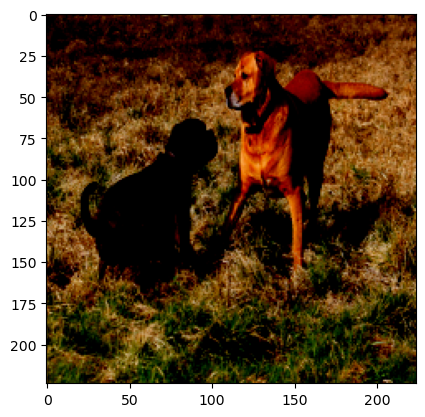

In [56]:
plt.imshow(inputs.permute(1, 2, 0))

In [57]:
print(decoded_out)

A brown dog and a black dog play in the grass.


In [58]:
torch.save(model.state_dict(), 'img_caption_model_weights.pt')
torch.save(model, 'img_caption_model.pt')